In [1]:
import numpy as np

def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]

    labels = None
    loss = 0

    for _ in range(max_iter):

        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        loss = np.sum(np.min(distances, axis=1))

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels, loss

In [4]:
from scipy.stats import multivariate_normal
def em_gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3):
    """ Implements EM for Gaussian Mixture Models

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations
    init_kmeans: whether kmeans should be used for initialisation
    eps: when log likelihood difference is smaller than eps, terminate loop

    Output:
    pi: 1 x k matrix of priors
    mu: (d x k) matrix with each cluster center in one column
    sigma: list of d x d covariance matrices
    """

    def expectation(X, pi, mu, sigma):
        """
        Expectation step of the EM algorithm.

        Args:
          X: The data points.
          pi: The weights of each Gaussian component.
          mu: The means of the Gaussian components.
          sigma: The covariance matrices of the Gaussian components.

        Returns:
          A matrix containing the responsibilities (posterior probabilities)
          of each data point belonging to each Gaussian component.
        """
        n, d = X.shape
        K = pi.shape[0]
        gamma = np.zeros((n, K))

        # Compute the responsibilities for each data point and each component
        for k in range(K):
            # Compute the probability density function of the Gaussian component
            pdf = multivariate_normal(mean=mu[k], cov=sigma[k]).pdf(X)
            # Compute the weighted probability
            gamma[:, k] = pi[k] * pdf

        # Normalize the responsibilities to get the posterior probabilities
        gamma_sum = gamma.sum(axis=1)[:, np.newaxis]
        gamma = gamma / gamma_sum
        return gamma

    def maximization(X, gamma):
        """
        Maximization step of the EM algorithm.

        Args:
          X: The data points.
          gamma: The responsibilities (posterior probabilities)
               of each data point belonging to each Gaussian component.

        Returns:
          Updated weights, means, and covariance matrices for the Gaussian components.
        """
        n, d = X.shape
        K = gamma.shape[1]

        # Initialize parameters
        mu = np.zeros((n, d))
        sigma = np.zeros((n, d, d))

        # Compute the weighted sum of responsibilities for each component
        Nk = gamma.sum(axis=0)

        # Update the mixture weights
        pi = Nk / n

        # Update the means
        for k in range(K):
            mu[k, :] = np.sum(gamma[:, k][:, np.newaxis] * X, axis=0) / Nk[k]

        # Update the covariance matrices
        for k in range(K):
            diff = X - mu[k]
            sigma[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]
        return pi, mu, sigma

    n, d = X.shape
    if init_kmeans:
        indices = kmeans(X, k, 100)[1]
    else:
        indices = np.random.choice(n, k, replace=False)
    mu = X[indices]

    # Initialize covariances to identity matrices
    sigma = [np.eye(d) for _ in range(k)]

    # Initialize weights to be equal
    pi = np.full(k, 1 / k)
    log_likelihood = 0
    for l in range(max_iter):
        gamma = expectation(X, pi, mu, sigma)
        prev_log_likelihood = np.sum(np.log(np.dot(gamma, pi.T)))
        pi, mu, sigma = maximization(X, gamma)
        log_likelihood = np.sum(np.log(np.dot(gamma, pi.T)))
        print(f"number of iterations: {l+1}, log likelihood: {log_likelihood}")
        if abs(log_likelihood - prev_log_likelihood) < eps:
            break
    return pi, mu, sigma, log_likelihood

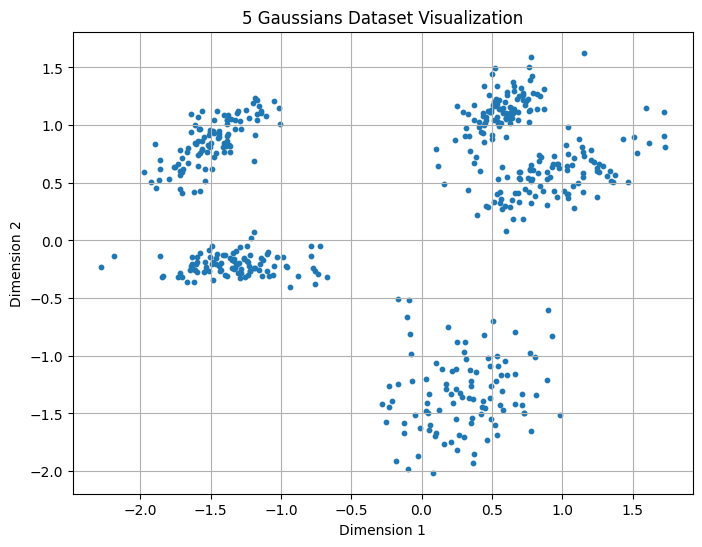

In [15]:
import matplotlib.pyplot as plt

data = np.load('/Users/yanqingluo/Desktop/LabML/git/problem_set2/data/5_gaussians.npy')
data = data.T
data_mean = np.mean(data)
data_std = np.std(data)
data = (data - data_mean) / data_std
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.title('5 Gaussians Dataset Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

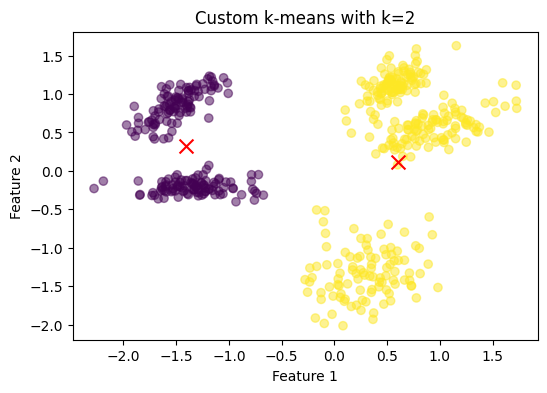

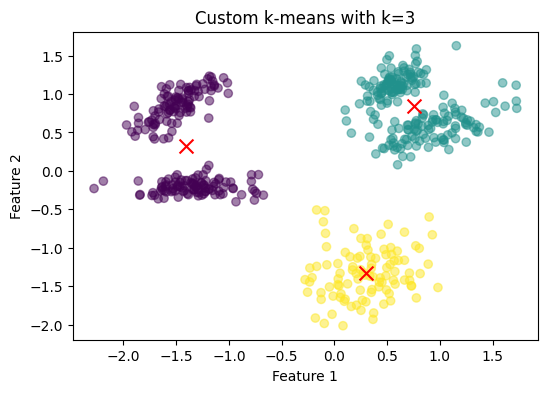

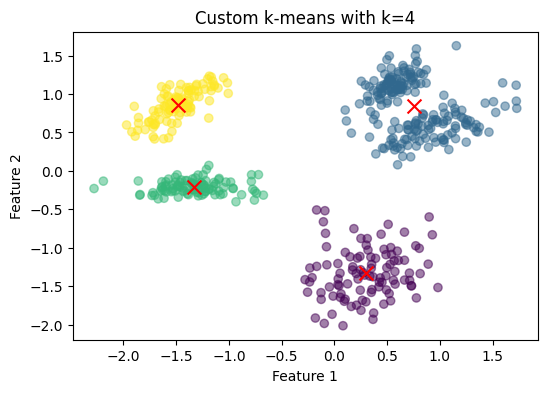

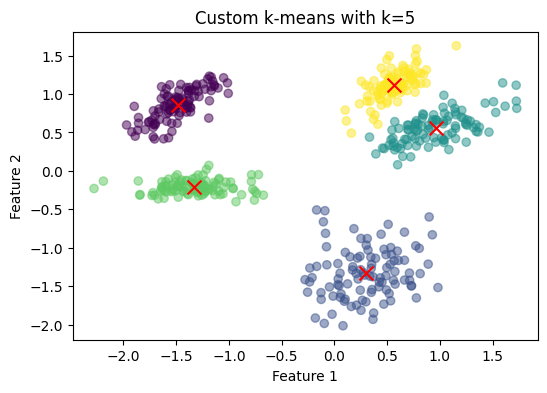

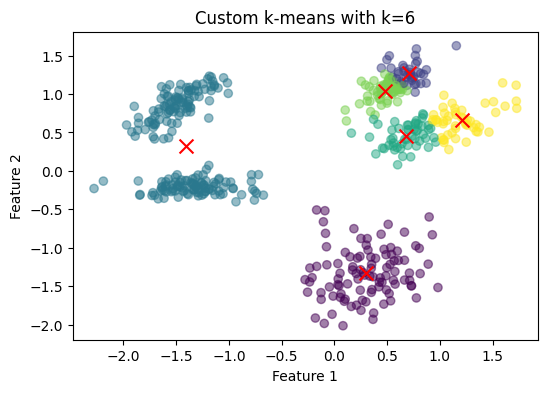

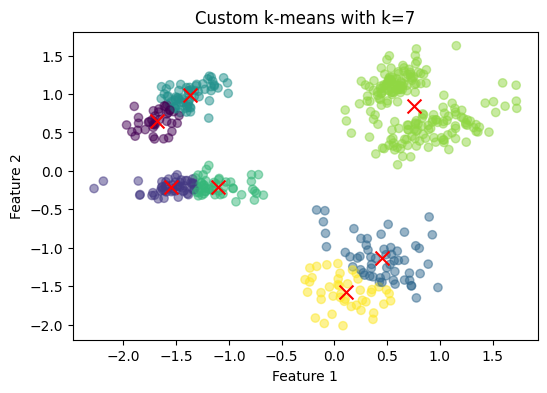

In [16]:
results_kmeans = {}
for k in range(2, 8):
    centroids, labels, loss = kmeans(data, k)
    results_kmeans[k] = (centroids, labels)

    # Plotting each k-means result
    plt.figure(figsize=(6, 4))
    plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.5, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x')  # mark centroids
    plt.title(f'Custom k-means with k={k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

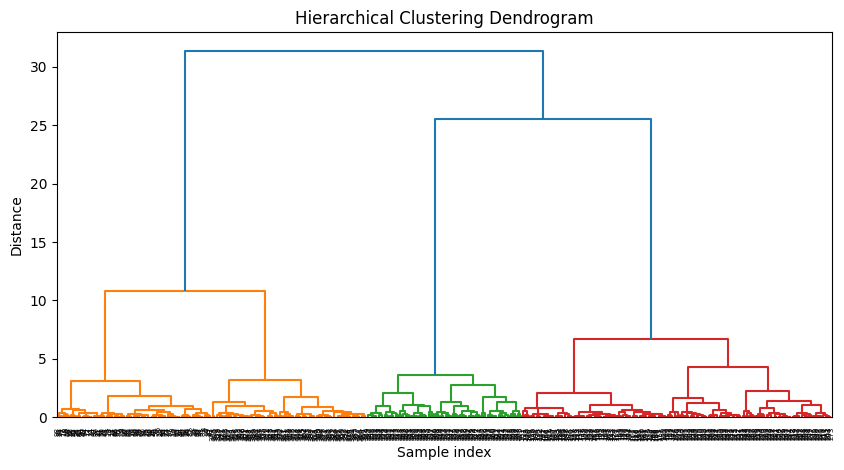

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [18]:
from scipy.stats import multivariate_normal

def gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3, kmeans_func=None):
    """ Implements EM for Gaussian Mixture Models """
    n, d = X.shape  # Number of samples (n) and dimensions (d)
    
    # Initialize means using kmeans or randomly
    if init_kmeans:
        if kmeans_func is None:
            raise ValueError("kmeans function must be provided for initialization with kmeans")
        _, indices, _ = kmeans_func(X, k, 100)
    else:
        indices = np.random.choice(n, k, replace=False)
    mu = X[indices, :]  # Initial means

    # Initialize covariances to identity matrices
    sigma = [np.eye(d) for _ in range(k)]

    # Initialize weights to be equal
    pi = np.full(k, 1 / k)
    log_likelihood = 0

    def expectation(X, pi, mu, sigma):
        """ Calculate responsibilities (gamma) """
        gamma = np.zeros((n, k))
        for j in range(k):
            pdf = multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X)
            gamma[:, j] = pi[j] * pdf
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma

    def maximization(X, gamma):
        """ Update pi, mu, and sigma """
        Nk = gamma.sum(axis=0)  # Sum responsibilities for each cluster
        pi = Nk / n
        mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]
        sigma = [np.dot((gamma[:, j][:, np.newaxis] * (X - mu[j])).T, X - mu[j]) / Nk[j] for j in range(k)]
        return pi, mu, sigma

    for l in range(max_iter):
        gamma = expectation(X, pi, mu, sigma)
        prev_log_likelihood = log_likelihood
        log_likelihood = np.sum(np.log(np.dot(gamma, pi)))
        pi, mu, sigma = maximization(X, gamma)
        if np.abs(log_likelihood - prev_log_likelihood) < eps:
            break
        print(f"number of iterations: {l+1}, log likelihood: {log_likelihood}")
    
    return pi, mu, sigma, log_likelihood, gamma


number of iterations: 1, log likelihood: -346.5735902799727
number of iterations: 2, log likelihood: -342.24018460866273
number of iterations: 3, log likelihood: -343.4232556147975
number of iterations: 4, log likelihood: -342.44703532478877
number of iterations: 5, log likelihood: -339.9401872291278
number of iterations: 6, log likelihood: -337.3861023022823
number of iterations: 7, log likelihood: -336.5181608098685
number of iterations: 8, log likelihood: -336.4351377242425
number of iterations: 9, log likelihood: -336.4298709460913


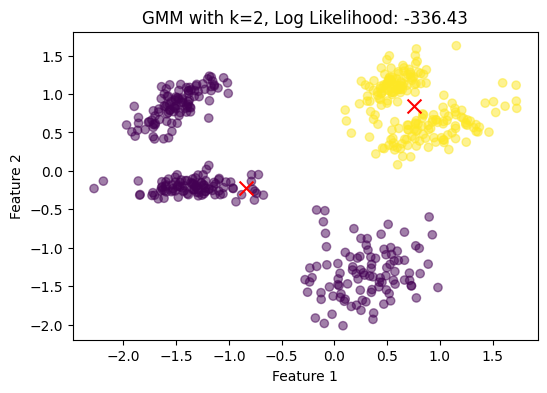

number of iterations: 1, log likelihood: -549.3061443340548
number of iterations: 2, log likelihood: -540.5132964352746
number of iterations: 3, log likelihood: -529.7191496975951
number of iterations: 4, log likelihood: -518.7639245557561
number of iterations: 5, log likelihood: -513.9855217579766
number of iterations: 6, log likelihood: -512.0356182970896
number of iterations: 7, log likelihood: -510.85941434140494
number of iterations: 8, log likelihood: -510.10017648176773
number of iterations: 9, log likelihood: -509.1827352033897
number of iterations: 10, log likelihood: -508.08803489621636
number of iterations: 11, log likelihood: -506.84000355640995
number of iterations: 12, log likelihood: -505.48276035202485
number of iterations: 13, log likelihood: -504.0996989700685
number of iterations: 14, log likelihood: -502.82148431989407
number of iterations: 15, log likelihood: -501.8180950895015
number of iterations: 16, log likelihood: -501.2725183000777
number of iterations: 17, l

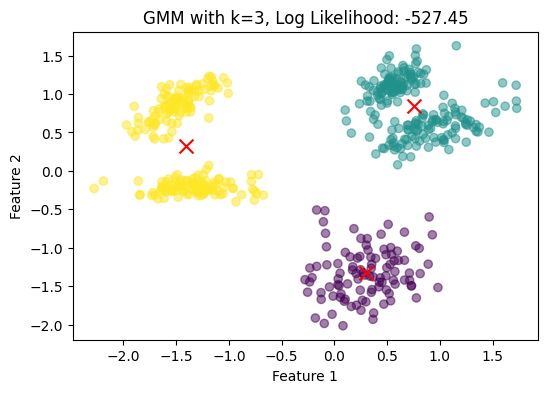

number of iterations: 1, log likelihood: -693.1471805599454
number of iterations: 2, log likelihood: -674.1204582943998
number of iterations: 3, log likelihood: -676.6055311322784
number of iterations: 4, log likelihood: -673.2652009205303
number of iterations: 5, log likelihood: -669.436221368776
number of iterations: 6, log likelihood: -666.4055892169099
number of iterations: 7, log likelihood: -665.8461523134699
number of iterations: 8, log likelihood: -665.8314026578666
number of iterations: 9, log likelihood: -665.8226092124698
number of iterations: 10, log likelihood: -665.8088671752299
number of iterations: 11, log likelihood: -665.7883521110149
number of iterations: 12, log likelihood: -665.7575467275321
number of iterations: 13, log likelihood: -665.7076386189842
number of iterations: 14, log likelihood: -665.6200208366109
number of iterations: 15, log likelihood: -665.4683561102481
number of iterations: 16, log likelihood: -665.235628810316
number of iterations: 17, log likel

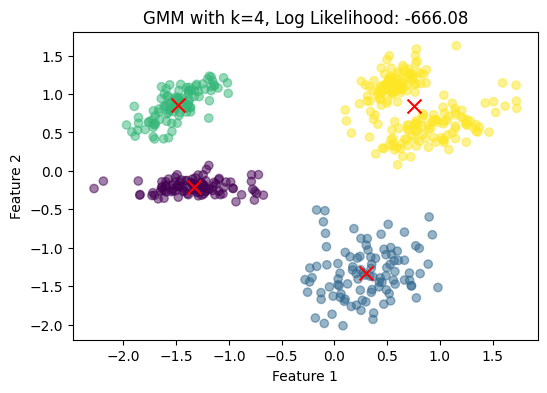

number of iterations: 1, log likelihood: -804.7189562170499
number of iterations: 2, log likelihood: -683.6696625412183
number of iterations: 3, log likelihood: -660.9001010473752
number of iterations: 4, log likelihood: -647.557350811232
number of iterations: 5, log likelihood: -638.9559771840105
number of iterations: 6, log likelihood: -636.5035380125512
number of iterations: 7, log likelihood: -638.6057845666867
number of iterations: 8, log likelihood: -642.6203433853399
number of iterations: 9, log likelihood: -647.4020785467486
number of iterations: 10, log likelihood: -652.8516709061764
number of iterations: 11, log likelihood: -660.2100099418108
number of iterations: 12, log likelihood: -672.1111536876953
number of iterations: 13, log likelihood: -690.5483526424789
number of iterations: 14, log likelihood: -711.7486074004825
number of iterations: 15, log likelihood: -725.564815311425
number of iterations: 16, log likelihood: -730.5183575270717
number of iterations: 17, log likel

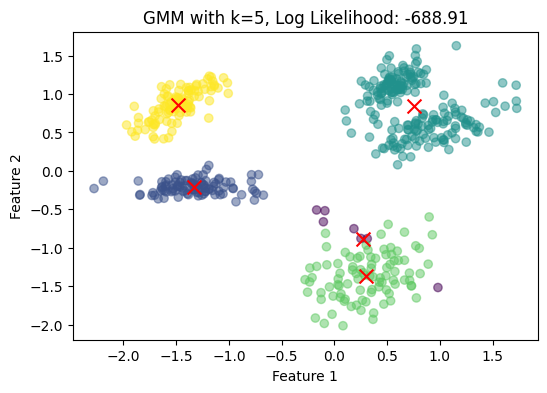

number of iterations: 1, log likelihood: -895.8797346140275
number of iterations: 2, log likelihood: -842.7507735068737
number of iterations: 3, log likelihood: -818.2032877846009
number of iterations: 4, log likelihood: -798.969859407703
number of iterations: 5, log likelihood: -782.7050186124587
number of iterations: 6, log likelihood: -775.8990743189263
number of iterations: 7, log likelihood: -774.2191174116339
number of iterations: 8, log likelihood: -776.2844657986315
number of iterations: 9, log likelihood: -783.0388114078983
number of iterations: 10, log likelihood: -784.3279563683152
number of iterations: 11, log likelihood: -760.9357363067936
number of iterations: 12, log likelihood: -732.6183139577604
number of iterations: 13, log likelihood: -713.6956674118496
number of iterations: 14, log likelihood: -703.6072091943769
number of iterations: 15, log likelihood: -699.3894195463944
number of iterations: 16, log likelihood: -697.848789334252
number of iterations: 17, log likel

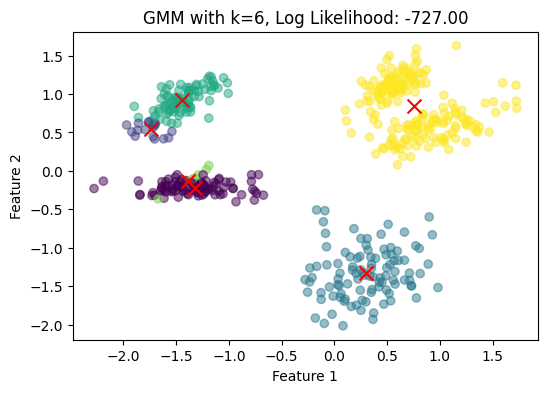

number of iterations: 1, log likelihood: -972.955074527657
number of iterations: 2, log likelihood: -957.2730445127087
number of iterations: 3, log likelihood: -958.2588547303361
number of iterations: 4, log likelihood: -954.8191467503309
number of iterations: 5, log likelihood: -949.9997932011731
number of iterations: 6, log likelihood: -951.4545834489686
number of iterations: 7, log likelihood: -943.6654279452522
number of iterations: 8, log likelihood: -927.2756528421683
number of iterations: 9, log likelihood: -910.1849986043222
number of iterations: 10, log likelihood: -894.9740624009132
number of iterations: 11, log likelihood: -882.2302946459974
number of iterations: 12, log likelihood: -872.1132516400942
number of iterations: 13, log likelihood: -864.9342366136509
number of iterations: 14, log likelihood: -859.883962879104
number of iterations: 15, log likelihood: -852.3003387924607
number of iterations: 16, log likelihood: -842.4129385825115
number of iterations: 17, log likel

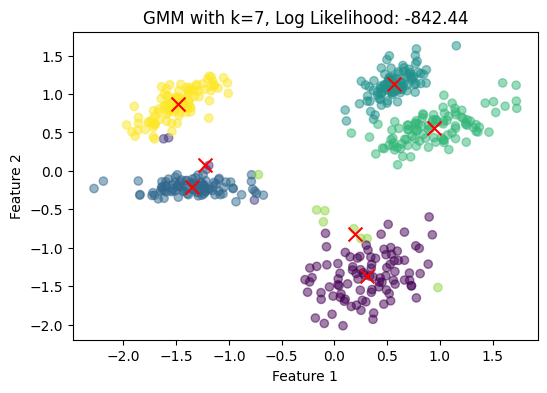

In [20]:
results_gmm = {}
for k in range(2, 8):
    pi, mu, sigma, log_likelihood, gamma = gmm(data, k, init_kmeans=False, eps=1e-3, kmeans_func=kmeans)
    labels = np.argmax(gamma, axis=1)  # Correctly use gamma to extract labels

    results_gmm[k] = (mu, sigma, labels)

    # Plotting each GMM result
    plt.figure(figsize=(6, 4))
    plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.5, cmap='viridis')
    plt.scatter(mu[:, 0], mu[:, 1], c='red', s=100, marker='x')  # Mark cluster centers
    plt.title(f'GMM with k={k}, Log Likelihood: {log_likelihood:.2f}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
